# Exploration and transformation of the IMDb (Internet Movie Database) dataset

additional information and all mentioned and created files can be seen at https://github.com/loprikas/Semantic_Web

In this document I will explain the concrete process of transforming the IMDb into a machine readable, semantically rich form by: 
1. Biulding an ontology graph in turtle based on the data provided by the official imdb page
2. writing a python script to fill the ontology with real data using RDF
3. uploading the dataset into an rdf-triple store
4. writing SPARQL Queries to receive and test data

# 1. Ontology


## 1.1 visualizing the data
By visualizing the data I could get a better overview of: what data is specifically there, how is the data represented, how the data is connected with each other and what data I can get out of which table. 

I visualized the data within the transformation script with this code.
By running the snippit you can view it. 

In [19]:
import re
import pandas as pd
from os import listdir
from os.path import isfile, join
from rdflib import Dataset, URIRef, Literal, Namespace, RDF, RDFS, OWL, XSD
from iribaker import to_iri
from tqdm import tqdm
# display in cmd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)

path = "../data"

files = [re.sub(r"\.tsv\.gz$", "", f) for f in listdir(path) if isfile(join(path, f)) and f.endswith(".tsv.gz")]

data_dict = {}

for file in files:
    file_path = f"{path}/{file}.tsv.gz"
    try:
        df = pd.read_csv(
            file_path,
            sep="\t",
            compression="gzip",
            on_bad_lines="skip"
        )
        data_dict[file] = df
        print(f"[✓] Erfolgreich geladen: {file}")
    except Exception as e:
        print(f"[!] Fehler beim Laden von '{file}': {e}")

# output
for key, value in data_dict.items():
    print(key)
    print(value.head())

[✓] Erfolgreich geladen: short.name.basic
[✓] Erfolgreich geladen: short.title.akas
[✓] Erfolgreich geladen: short.title.basics
[✓] Erfolgreich geladen: short.title.crew
[✓] Erfolgreich geladen: short.title.episode
[✓] Erfolgreich geladen: short.title.pricipals
[✓] Erfolgreich geladen: short.title.ratings
short.name.basic
      nconst      primaryName birthYear deathYear                   primaryProfession                           knownForTitles
0  nm0000001     Fred Astaire      1899      1987        actor,miscellaneous,producer  tt0072308,tt0050419,tt0027125,tt0031983
1  nm0000002    Lauren Bacall      1924      2014  actress,soundtrack,archive_footage  tt0037382,tt0075213,tt0117057,tt0038355
2  nm0000003  Brigitte Bardot      1934        \N   actress,music_department,producer  tt0057345,tt0049189,tt0056404,tt0054452
3  nm0000004     John Belushi      1949      1982       actor,writer,music_department  tt0072562,tt0077975,tt0080455,tt0078723
4  nm0000005   Ingmar Bergman      1918  

This knowledge is helpful for defining data types. I chose mostly strings and integers and had to change the gYear type into string as well, because the fallback values for start- and endYear are strings ("\N").

## 1.2 creating the ontology

To show different stages of the ontology creating process, I will add the turtle file for the newest version, after that I will add pictures (SVGs) of the newest, the first and second version to visualize the progress from the idea of an knowledge graph to the refined ontology. I have more ontology versions in between on github, but the changes between them are much smaller, therefore I'm just showing 2 versions.  

In [ ]:
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix imd:   <http://example.org/imdb#> .
@prefix dc:    <http://purl.org/dc/terms/> .

###############################################################################
# Ontology Metadata
###############################################################################
imd:  a owl:Ontology ;
    dc:title       "IMDb Ontology" ;
    dc:creator     "Pascal Henrici" ;
    dc:description "Ontology for IMDb" ;
    owl:versionInfo "6.0" .

###############################################################################
# Classes
###############################################################################
imd:Title        a owl:Class ; rdfs:label "Title" .
imd:TVSeries     a owl:Class ; rdfs:label "TV Series" ; rdfs:subClassOf imd:Title .
imd:Episode      a owl:Class ; rdfs:label "Episode"   ; rdfs:subClassOf imd:Title .
imd:Person       a owl:Class ; rdfs:label "Person" .
imd:Role         a owl:Class ; rdfs:label "Role" .
imd:Rating       a owl:Class ; rdfs:label "Rating" .
imd:AlternateTitle a owl:Class ; rdfs:label "Alternate Title" .
###############################################################################
# Object Properties
###############################################################################
imd:hasRole        a owl:ObjectProperty ; rdfs:domain imd:Person ;    rdfs:range imd:Role ;      rdfs:label "hasRole" .
imd:roleIn         a owl:ObjectProperty ; rdfs:domain imd:Role ;      rdfs:range imd:Title ;     rdfs:label "roleOf" .
imd:knownFor       a owl:ObjectProperty ; rdfs:domain imd:Person ;    rdfs:range imd:Title ;     rdfs:label "knownFor" .
imd:hasRating      a owl:ObjectProperty ; rdfs:domain imd:Title ;     rdfs:range imd:Rating ;    rdfs:label "hasRating" .
imd:hasAlternateTitle a owl:ObjectProperty ; rdfs:domain imd:Title ;   rdfs:range imd:AlternateTitle ; rdfs:label "hasAlternateTitle" .
imd:parentSeries   a owl:ObjectProperty ; rdfs:domain imd:Episode ;   rdfs:range imd:TVSeries ;  rdfs:label "parentSeries" .
###############################################################################
# Datatype Properties
###############################################################################
# Title
imd:titleID         a owl:DatatypeProperty ; rdfs:domain imd:Title  ; rdfs:range xsd:string  ; rdfs:label "titleID" .
imd:primaryTitle    a owl:DatatypeProperty ; rdfs:domain imd:Title  ; rdfs:range xsd:string  ; rdfs:label "primaryTitle" .
imd:originalTitle   a owl:DatatypeProperty ; rdfs:domain imd:Title  ; rdfs:range xsd:string  ; rdfs:label "originalTitle" .
imd:isAdult         a owl:DatatypeProperty ; rdfs:domain imd:Title  ; rdfs:range xsd:boolean ; rdfs:label "isAdult" .
imd:startYear       a owl:DatatypeProperty ; rdfs:domain imd:Title  ; rdfs:range xsd:string   ; rdfs:label "startYear" .
imd:endYear         a owl:DatatypeProperty ; rdfs:domain imd:Title  ; rdfs:range xsd:string   ; rdfs:label "endYear" .
imd:runtimeMinutes  a owl:DatatypeProperty ; rdfs:domain imd:Title  ; rdfs:range xsd:integer ; rdfs:label "runtimeMinutes" .
imd:genre           a owl:DatatypeProperty ; rdfs:domain imd:Title  ; rdfs:range xsd:string  ; rdfs:label "genre" ;.
imd:type            a owl:DatatypeProperty ; rdfs:domain imd:Title  ; rdfs:range xsd:string  ; rdfs:label "type" ;.
# Rating
imd:averageRating   a owl:DatatypeProperty ; rdfs:domain imd:Rating ; rdfs:range xsd:decimal ; rdfs:label "averageRating" .
imd:numVotes        a owl:DatatypeProperty ; rdfs:domain imd:Rating ; rdfs:range xsd:integer ; rdfs:label "numVotes" .
# Person
imd:personID        a owl:DatatypeProperty ; rdfs:domain imd:Person ; rdfs:range xsd:string  ; rdfs:label "personID" .
imd:birthYear       a owl:DatatypeProperty ; rdfs:domain imd:Person ; rdfs:range xsd:string   ; rdfs:label "birthYear" .
imd:deathYear       a owl:DatatypeProperty ; rdfs:domain imd:Person ; rdfs:range xsd:string  ; rdfs:label "deathYear" .
imd:gender          a owl:DatatypeProperty ; rdfs:domain imd:Person ; rdfs:range xsd:string  ; rdfs:label "gender" .
# Alternate Title
imd:order           a owl:DatatypeProperty ; rdfs:domain imd:AlternateTitle ; rdfs:range xsd:integer ; rdfs:label "order" .
imd:alternateTitle  a owl:DatatypeProperty ; rdfs:domain imd:AlternateTitle ; rdfs:range xsd:string  ; rdfs:label "alternateTitle" .
imd:region          a owl:DatatypeProperty ; rdfs:domain imd:AlternateTitle ; rdfs:range xsd:string  ; rdfs:label "region" .
imd:language        a owl:DatatypeProperty ; rdfs:domain imd:AlternateTitle ; rdfs:range xsd:string  ; rdfs:label "language" .
# Episode
imd:seasonNumber    a owl:DatatypeProperty ; rdfs:domain imd:Episode ; rdfs:range xsd:integer ; rdfs:label "seasonNumber" .
imd:episodeNumber   a owl:DatatypeProperty ; rdfs:domain imd:Episode ; rdfs:range xsd:integer ; rdfs:label "episodeNumber" .
# TV Series:
imd:seriesTitle     a owl:DatatypeProperty ; rdfs:domain imd:TVSeries ; rdfs:range xsd:string ; rdfs:label "seriesTitle" .
# Role:
imd:roleName        a owl:DatatypeProperty ; rdfs:domain imd:Role   ; rdfs:range xsd:string ; rdfs:label "roleName" .



In [9]:
from IPython.display import SVG, display

## current version

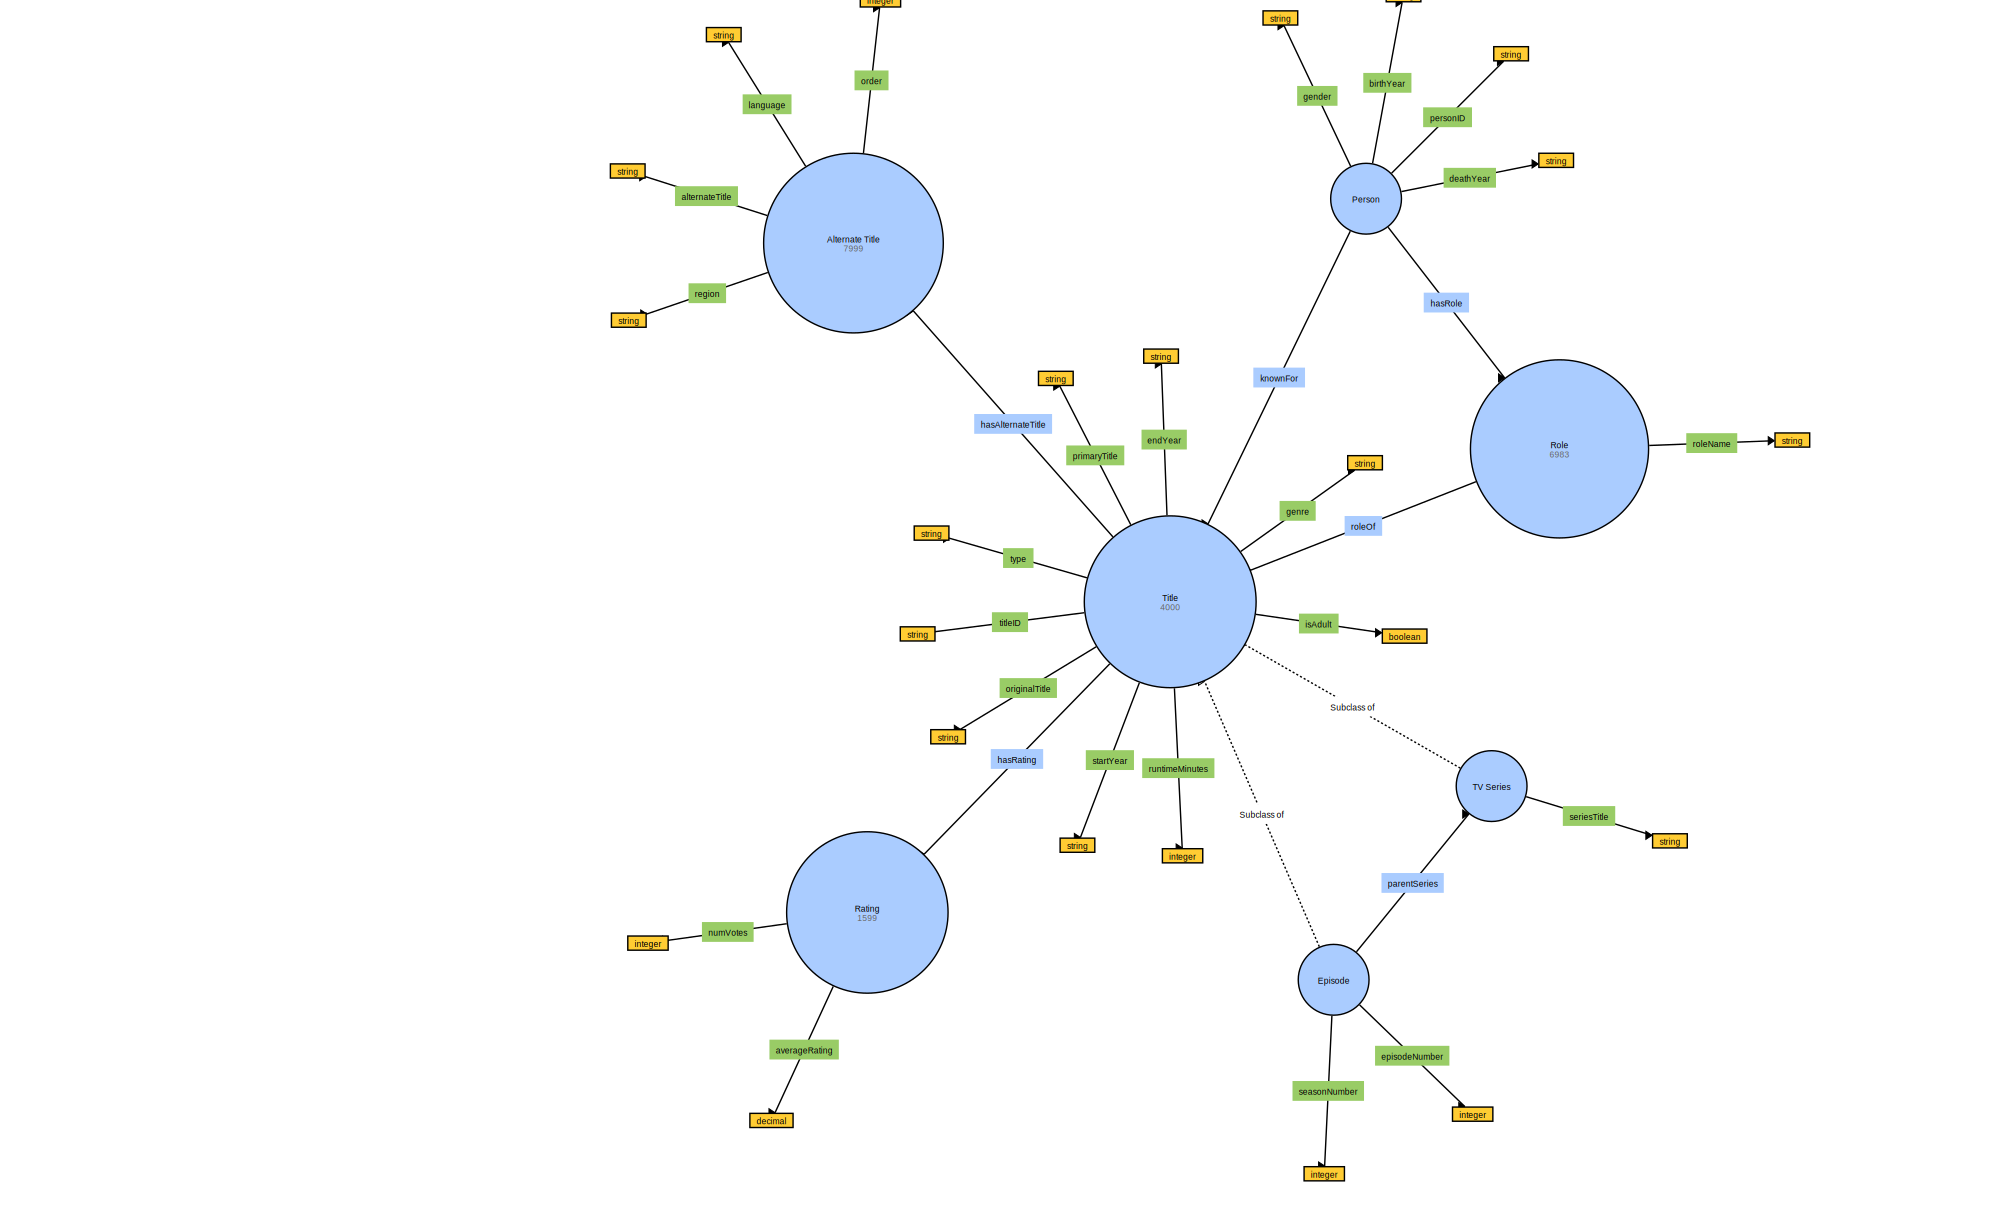

In [13]:
display(SVG(filename="imdb_sample_100k.ttl.svg"))

## second version

the second version was a little bit overengineered, also it didn't follow the rule that a class needs at least one property. I got told that on Semantic Web Day and found it an important lesson. 

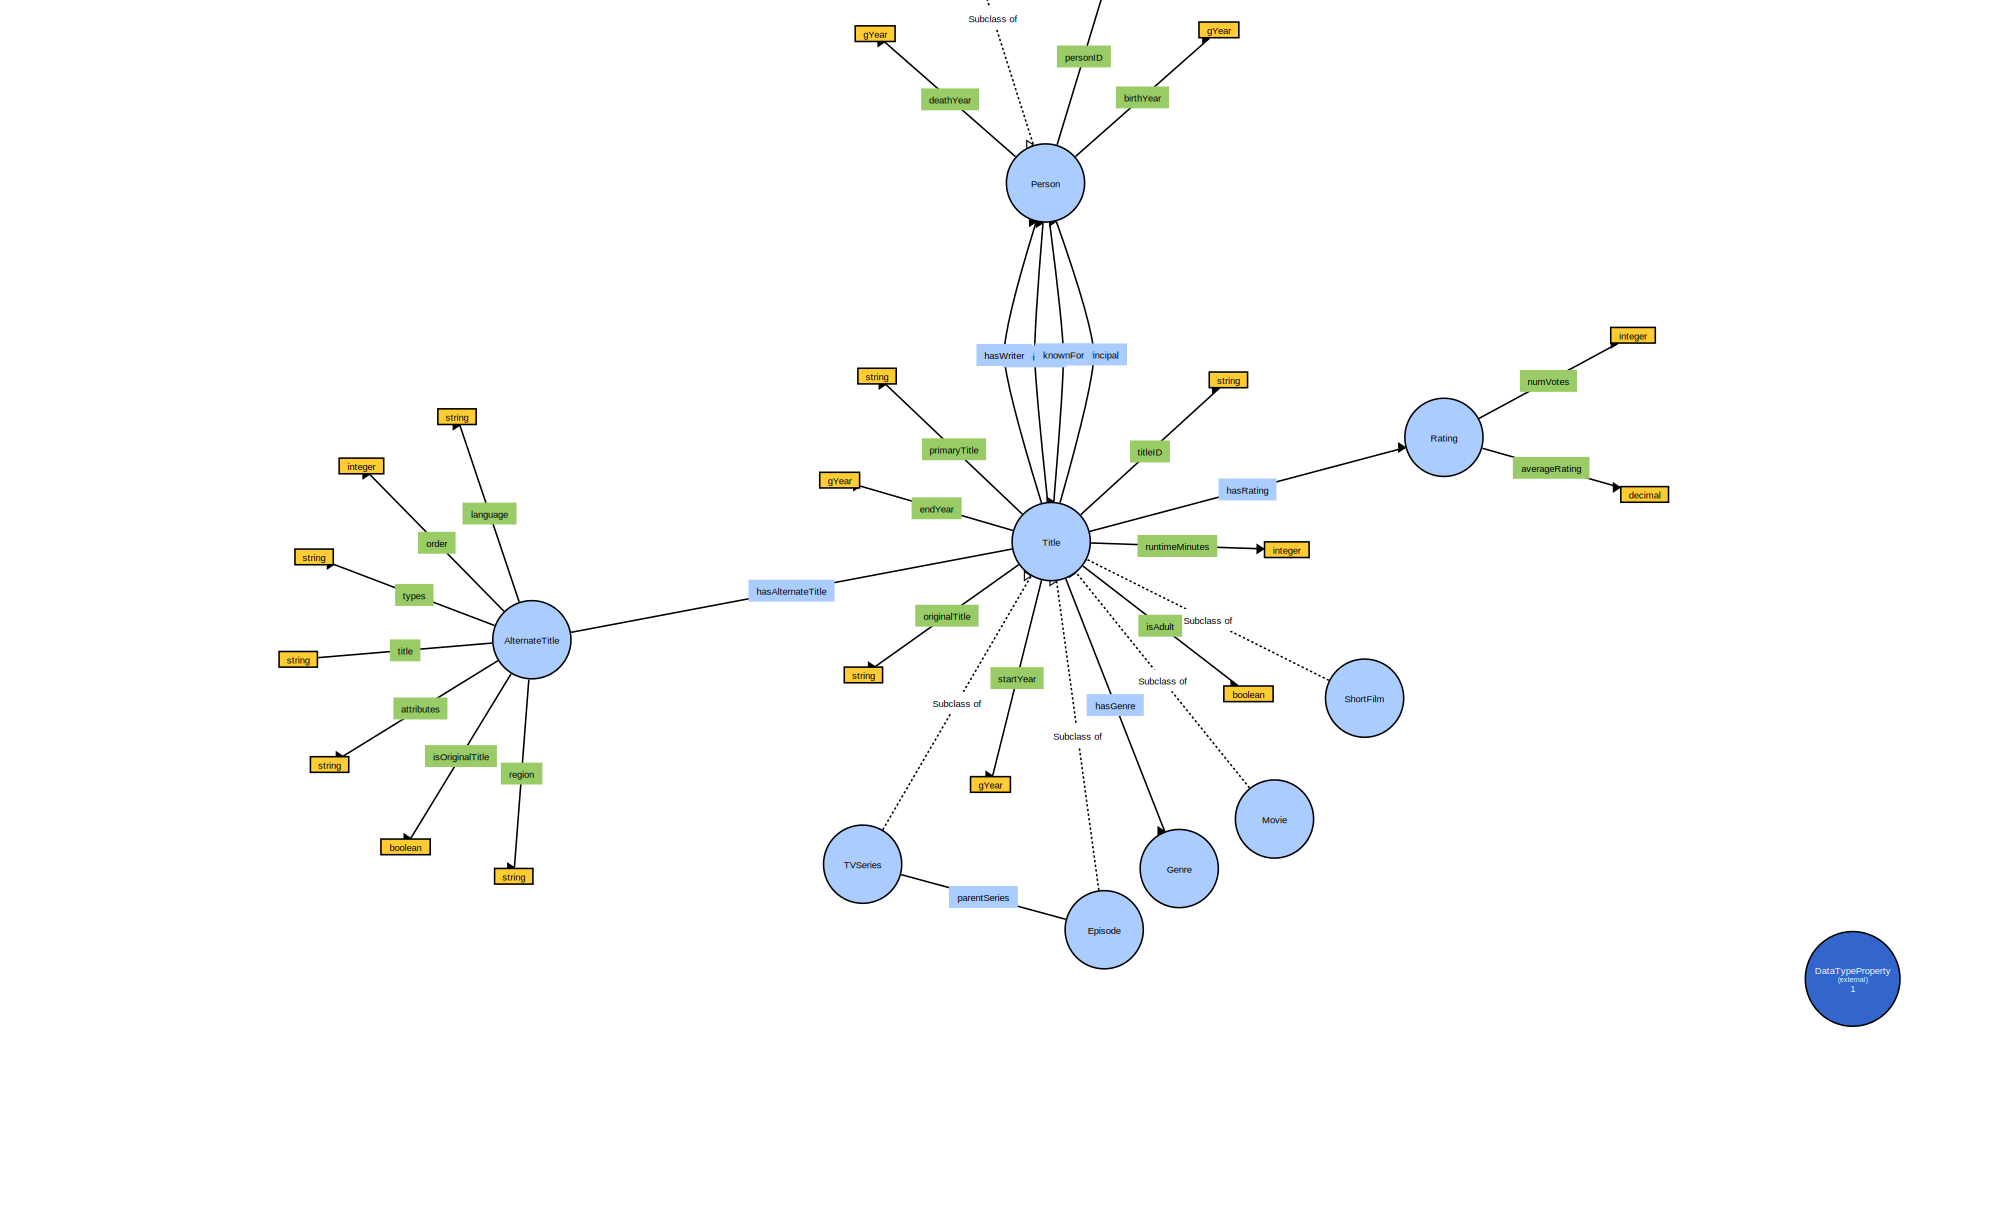

In [15]:
display(SVG(filename="imdb_2.0.ttl.svg"))

## first version

The first version was more of a sketch of how I imagined a movie Database in general. 

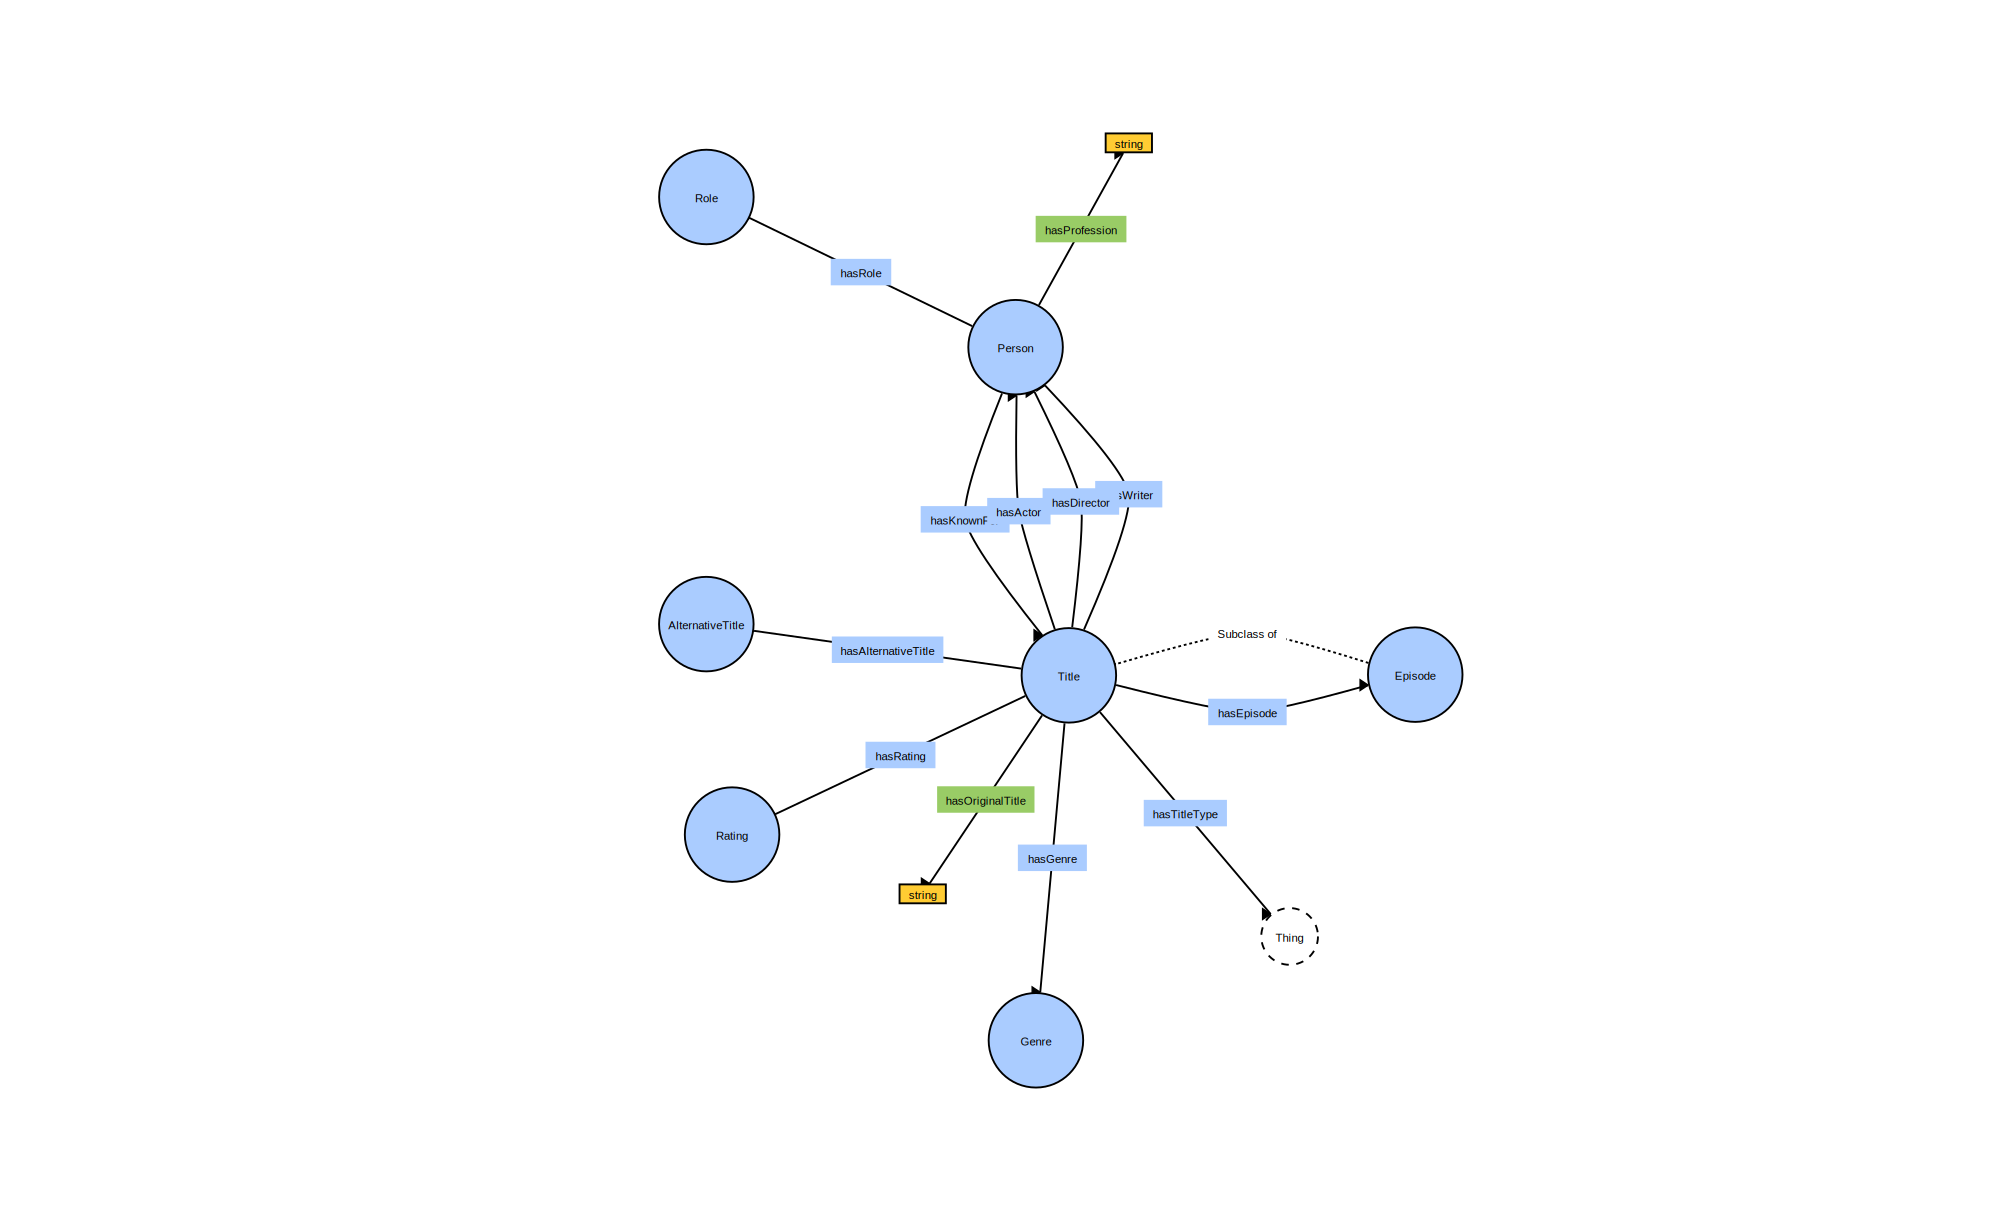

In [14]:
display(SVG(filename="imdb_1.0.ttl.svg"))

# 2. RDF Transformation Python Scripts

## 2.1 prep 

For preparation you have to set the namespaces and initialize the graph and load the ontology as base.

In [20]:
# ---------------------- TRANSFORMATION -------------------------------
# Prep #
# A namespaces
data = 'http://imdb.aksw.org/ontology#'
DATA = Namespace(data)
vocab = 'http://imdb.aksw.org/ontology#'
VOCAB = Namespace(vocab)
graph_uri = URIRef('http://imdb.aksw.org/ontology#')
dataset = Dataset()
dataset.bind('imdb_data', DATA)
dataset.bind('imdb_vocab', VOCAB)

# We then get a new graph object with our URI from the dataset.
graph = dataset.graph(graph_uri)

# Load the externally defined schema into the default graph (context) of the dataset
dataset.default_context.parse('imdb_ontology.ttl', format='turtle')

<Graph identifier=urn:x-rdflib:default (<class 'rdflib.graph.Graph'>)>

## 2.2 defining URIs

Here I will show the first version first. I created the URIs for those classes first, that have only one connection to the main "title" class and initialized their properties. 
I stopped at the main title class and used AI from there on, because I found it pretty hard to understand how to define the subclasses and classes with multiple connections. Also the relationships between the tables seemed quite complex. 

In [ ]:
# creating URIs for rating

for index, row in tqdm(data_dict["short.title.ratings"].iterrows()):
    rating = URIRef(to_iri(f"{data}Rating{row['tconst']}"))

    rating_number = Literal(row["averageRating"], datatype=XSD['string'])
    ratings_amount = Literal(row["numVotes"], datatype=XSD['string'])

    graph.add((rating, RDF.type, VOCAB['Rating']))

    graph.add((rating, VOCAB['averageRating'], rating_number))
    graph.add((rating, VOCAB['numVotes'], ratings_amount))

# creating URIs for alternate titles

for index, row in tqdm(data_dict["short.title.akas"].iterrows()):
    alternate_title = URIRef(to_iri(f"{data}Alternate Title{row['titleId']}-{row['region']}-{row['language']}"))

    a_title = Literal(row["title"], datatype=XSD['string'])
    region = Literal(row["region"], datatype=XSD['string'])
    language = Literal(row["language"], datatype=XSD['string'])

    graph.add((alternate_title, RDF.type, VOCAB['Alternate Title']))

    graph.add((alternate_title, VOCAB['alternateTitle'], a_title))
    graph.add((alternate_title, VOCAB['region'], region))
    graph.add((alternate_title, VOCAB['language'], language))


# creating URIs for persons

for index, row in tqdm(data_dict["short.name.basic"].iterrows()):
    person = URIRef(to_iri(f"{data}Person{row['nconst']}"))

    birth_year = Literal(row["birthYear"], datatype=XSD['string'])
    death_year = Literal(row["deathYear"], datatype=XSD['string'])
    name = Literal(row["primaryName"], datatype=XSD['string'])
    if "actor" in str(row["primaryProfession"]):
        gender = Literal("male", datatype=XSD['string'])
    elif "actress" in str(row["primaryProfession"]):
        gender = Literal("female", datatype=XSD['string'])
    else:
        gender = Literal("unknown", datatype=XSD['string'])

    graph.add((person, RDF.type, VOCAB['Person']))

    graph.add((person, VOCAB['year of birth'], birth_year))
    graph.add((person, VOCAB['year of death'], death_year))
    graph.add((person, VOCAB['gender'], gender))

    # creating URIs for titles

for index, row in tqdm(data_dict["short.title.basics"].iterrows()):
    title = URIRef(to_iri(f"{data}Title{row['tconst']}"))

    runtime = Literal(row["runtimeMinutes"], datatype=XSD['string'])
    release_year = Literal(row["startYear"], datatype=XSD['string'])
    genres = Literal(row["genres"], datatype=XSD['string'])
    original_title = Literal(row["originalTitle"], datatype=XSD['string'])
    title_type = Literal(row["titleType"], datatype=XSD['string'])

    graph.add((title, RDF.type, VOCAB['Title']))

    graph.add((title, VOCAB['runtime'], runtime))
    graph.add((title, VOCAB['release year'], release_year))
    graph.add((title, VOCAB['genres'], genres))
    graph.add((title, VOCAB['title'], original_title))
    graph.add((title, VOCAB['type'], title_type))

For the first real run with the following script I only loaded the sample tables with only 100 rows. After that I loaded the full tables, which created a huge file of 130GB in a span of 8-10 hours.

In the first run with the complete tables my PC froze because my RAM was fully allocated, which I then fixed by chunking the data and flushing the RAM after every chunk.

In [ ]:
# ---------------------- TRANSFORMATION (RAM-safe, Reinit per Flush) -----------------------

from rdflib import Dataset, URIRef, Namespace, Literal, XSD, RDFS, RDF
from iribaker import to_iri
import pandas as pd
import re
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import gc

# Namespaces
RES = Namespace('http://example.org/imdb/resource/')
IMD = Namespace('http://example.org/imdb#')

# Helping functions
def _new_graph():
    global dataset, graph
    dataset = Dataset()
    dataset.bind('res', RES)
    dataset.bind('imd', IMD)
    graph = dataset.default_context

# init
_new_graph()

# settings
OUT_TTL = 'imdb_transformed.ttl'
FLUSH_TRIPLES = 200_000

# flushing
def _flush_graph():
    global dataset, graph
    if len(graph):
        data = graph.serialize(format='nt')
        if isinstance(data, bytes):
            data = data.decode('utf-8')
        with open(OUT_TTL, 'a', encoding='utf-8') as f:
            f.write(data)
    # hard reset
    try:
        dataset.close()
    except Exception:
        pass
    del graph
    del dataset
    gc.collect()
    _new_graph()

# Turtle-Prefixes write only once
with open(OUT_TTL, 'w', encoding='utf-8') as f:
    f.write('@prefix res: <http://example.org/imdb/resource/> .\n')
    f.write('@prefix imd: <http://example.org/imdb#> .\n\n')

# Ontologie loading
dataset.default_context.parse('imdb_ontology.ttl', format='turtle')
_flush_graph()  

# path
path = "../uncutted files"

# file finding
files = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith(".tsv.gz")]

# log
print("[Info] Gefundene Dateien:")
for f in files:
    print(" -", f)

# loading files
def _iter_chunks(filename):
    file_path = f"{path}/{filename}"
    yield from pd.read_csv(
        file_path,
        sep="\t",                
        compression="gzip",
        on_bad_lines="skip",
        chunksize=100_000
    )

def _base(name: str) -> str:
    return re.sub(r"\.tsv\.gz$", "", name)

# URIs
    
# -------- Title (basics) --------
for df in _iter_chunks("title.basics.tsv.gz"):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        tconst = row["tconst"]
        t = URIRef(to_iri(f"{RES}title/{tconst}"))
        graph.add((t, RDF.type, IMD.Title))

        tt = "" if pd.isna(row.get("titleType")) else str(row.get("titleType"))
        if tt == "tvSeries":
            graph.add((t, RDF.type, IMD.TVSeries))
        if tt == "tvEpisode":
            graph.add((t, RDF.type, IMD.Episode))

        graph.add((t, IMD.titleID, Literal(str(tconst), datatype=XSD.string)))

        v = row.get("primaryTitle")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            graph.add((t, IMD.primaryTitle, Literal(str(v), datatype=XSD.string)))

        v = row.get("originalTitle")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            graph.add((t, IMD.originalTitle, Literal(str(v), datatype=XSD.string)))

        v = row.get("isAdult")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            s = str(v).lower()
            b = True if s in {'1', 'true', 't'} else False
            graph.add((t, IMD.isAdult, Literal(b, datatype=XSD.boolean)))

        v = row.get("startYear")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            try:
                graph.add((t, IMD.startYear, Literal(str(v), datatype=XSD.string)))
            except:
                pass

        v = row.get("endYear")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            try:
                graph.add((t, IMD.endYear, Literal(str(v), datatype=XSD.string)))
            except:
                pass

        v = row.get("runtimeMinutes")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            try:
                graph.add((t, IMD.runtimeMinutes, Literal(int(v), datatype=XSD.integer)))
            except:
                pass

        v = row.get("titleType")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            graph.add((t, IMD.type, Literal(str(v), datatype=XSD.string)))

        v = row.get("genres")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            for g_ in str(v).split(','):
                g = g_.strip()
                if g:
                    graph.add((t, IMD.genre, Literal(g, datatype=XSD.string)))
        # [ÄNDERUNG] Nur am Chunkende flushen, nicht zwischendurch
    _flush_graph()
    del df
    gc.collect()

# -------- Ratings --------
for df in _iter_chunks("title.ratings.tsv.gz"):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        tconst = row["tconst"]
        r = URIRef(to_iri(f"{RES}rating/{tconst}"))
        graph.add((r, RDF.type, IMD.Rating))

        v = row.get("averageRating")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            try:
                graph.add((r, IMD.averageRating, Literal(str(float(v)), datatype=XSD.decimal)))
            except:
                pass

        v = row.get("numVotes")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            try:
                graph.add((r, IMD.numVotes, Literal(int(v), datatype=XSD.integer)))
            except:
                pass

        t = URIRef(to_iri(f"{RES}title/{tconst}"))
        graph.add((t, IMD.hasRating, r))
    _flush_graph()
    del df
    gc.collect()

# -------- Alternate titles (akas) --------
for df in _iter_chunks("title.akas.tsv.gz"):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        titleId = row["titleId"]
        ordering = row.get("ordering")
        a = URIRef(to_iri(f"{RES}akas/{titleId}/{ordering}"))
        graph.add((a, RDF.type, IMD.AlternateTitle))

        if not pd.isna(ordering):
            try:
                graph.add((a, IMD.order, Literal(int(ordering), datatype=XSD.integer)))
            except:
                pass

        v = row.get("title")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            graph.add((a, IMD.alternateTitle, Literal(str(v), datatype=XSD.string)))

        v = row.get("region")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            graph.add((a, IMD.region, Literal(str(v), datatype=XSD.string)))

        v = row.get("language")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            graph.add((a, IMD.language, Literal(str(v), datatype=XSD.string)))

        t = URIRef(to_iri(f"{RES}title/{titleId}"))
        graph.add((t, IMD.hasAlternateTitle, a))
    _flush_graph()
    del df
    gc.collect()

# -------- Episodes --------
for df in _iter_chunks("title.episode.tsv.gz"):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        tconst = row["tconst"]
        t = URIRef(to_iri(f"{RES}title/{tconst}"))
        graph.add((t, RDF.type, IMD.Episode))

        v = row.get("seasonNumber")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            try:
                graph.add((t, IMD.seasonNumber, Literal(int(v), datatype=XSD.integer)))
            except:
                pass

        v = row.get("episodeNumber")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            try:
                graph.add((t, IMD.episodeNumber, Literal(int(v), datatype=XSD.integer)))
            except:
                pass

        parent = row.get("parentTconst")
        if not pd.isna(parent) and str(parent) not in {r'\N', '\\N', ''}:
            p = URIRef(to_iri(f"{RES}title/{parent}"))
            graph.add((t, IMD.parentSeries, p))
    _flush_graph()
    del df
    gc.collect()

# -------- Persons --------
for df in _iter_chunks("name.basics.tsv.gz"):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        nconst = row["nconst"]
        p = URIRef(to_iri(f"{RES}person/{nconst}"))
        graph.add((p, RDF.type, IMD.Person))
        graph.add((p, IMD.personID, Literal(str(nconst), datatype=XSD.string)))

        v = row.get("primaryName")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            graph.add((p, RDFS.label, Literal(str(v), datatype=XSD.string)))

        v = row.get("birthYear")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            try:
                graph.add((p, IMD.birthYear, Literal(str(v), datatype=XSD.string)))
            except:
                pass

        v = row.get("deathYear")
        if not pd.isna(v) and str(v) not in {r'\N', '\\N', ''}:
            try:
                graph.add((p, IMD.deathYear, Literal(str(v), datatype=XSD.string)))
            except:
                pass

        prof = "" if pd.isna(row.get("primaryProfession")) else str(row.get("primaryProfession"))
        if "actress" in prof:
            graph.add((p, IMD.gender, Literal("female", datatype=XSD.string)))
        elif "actor" in prof:
            graph.add((p, IMD.gender, Literal("male", datatype=XSD.string)))

        kf = row.get("knownForTitles")
        if not pd.isna(kf) and str(kf) not in {r'\N', '\\N', ''}:
            for tt in str(kf).split(","):
                tt_ = tt.strip()
                if tt_:
                    t = URIRef(to_iri(f"{RES}title/{tt_}"))
                    graph.add((p, IMD.knownFor, t))
    _flush_graph()
    del df
    gc.collect()

# -------- Roles aus crew --------
for df in _iter_chunks("title.crew.tsv.gz"):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        tconst = row["tconst"]
        for role_name, col in [("director", "directors"), ("writer", "writers")]:
            vals = row.get(col)
            if pd.isna(vals) or str(vals) in {r'\N', '\\N', ''}:
                continue
            for n in str(vals).split(","):
                nconst = n.strip()
                if not nconst:
                    continue
                person = URIRef(to_iri(f"{RES}person/{nconst}"))
                role = URIRef(to_iri(f"{RES}role/{tconst}/{role_name}/{nconst}"))
                t = URIRef(to_iri(f"{RES}title/{tconst}"))

                graph.add((role, RDF.type, IMD.Role))
                graph.add((role, IMD.roleName, Literal(role_name, datatype=XSD.string)))
                graph.add((person, IMD.hasRole, role))
                graph.add((role, IMD.roleIn, t))
    _flush_graph()
    del df
    gc.collect()

# -------- Roles aus principals --------
for df in _iter_chunks("title.principals.tsv.gz"):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        tconst = row.get("tconst")
        nconst = row.get("nconst")
        if pd.isna(tconst) or str(tconst) in {r'\N', '\\N', ''} or pd.isna(nconst) or str(nconst) in {r'\N', '\\N', ''}:
            continue

        cat = "" if pd.isna(row.get("category")) else str(row.get("category")).strip()
        if cat == "actress":
            cat = "actor"
        if not cat:
            job = row.get("job")
            cat = "" if pd.isna(job) else str(job).strip()
        if not cat:
            cat = "role"

        person = URIRef(to_iri(f"{RES}person/{nconst}"))
        role = URIRef(to_iri(f"{RES}role/{tconst}/{cat}/{nconst}"))
        t = URIRef(to_iri(f"{RES}title/{tconst}"))

        graph.add((role, RDF.type, IMD.Role))
        graph.add((role, IMD.roleName, Literal(cat, datatype=XSD.string)))
        graph.add((person, IMD.hasRole, role))
        graph.add((role, IMD.roleIn, t))
    _flush_graph()
    del df
    gc.collect()

# result
_flush_graph()
print(f"[✓] Fertig. Tripel in '{OUT_TTL}' geschrieben.")

![filesize_picture](filesize.png)

To prepare the data for the triple store I tried multiple things. First I zipped the filed to around 200 folders with a script, because I thought I could upload it that way, but realized too late that I could only upload 100k triples to triplyDB. So the final version of the code did the transformation for only 100k triples. To that state I let AI tweak the script multiple times, which led to a lot of changes in e.g. code style and use of helping functions.

In [ ]:
"""
Builds a representative IMDb RDF sample capped at 100k triples.
Prerequisites: Original IMDb .tsv.gz files located under IMDB_PATH.
Ontology file 'imdb_ontology.ttl' sits next to this script.

Covered classes/structures:
- imd:Title (+ subtypes imd:TVSeries, imd:Episode)
- imd:Rating and the link imd:hasRating
- imd:AlternateTitle and the link imd:hasAlternateTitle
- Episode relations: imd:seasonNumber, imd:episodeNumber, imd:parentSeries
- imd:Person, role nodes imd:Role with imd:roleName, imd:roleIn, imd:hasRole
- Basic attributes from title.basics and name.basics (label, birthYear, deathYear, simple gender heuristic)
- knownFor links

Logic mirrors your two ETL scripts, but adds a global triple budget
and a targeted per-file selection so all classes appear.
"""

from rdflib import Graph, URIRef, Namespace, Literal
from rdflib.namespace import RDF, RDFS, XSD
import pandas as pd
import gzip, os, re
from iribaker import to_iri
from typing import Set, Dict

# ------------------ Parameters ------------------
IMDB_PATH = "../uncutted files"   # path to .tsv.gz files
ONTOLOGY_FILE = "imdb_ontology.ttl"
OUT_FILE = "imdb_sample_100k.ttl"
MAX_TRIPLES = 100_000

# Sampling caps (upper bounds only; the global budget always wins)
SEED_TITLES_MAX         = 4000    # initial number of titles chosen from basics
AKAS_PER_TITLE_MAX      = 2
EPISODES_PER_SERIES_MAX = 10
PRINCIPALS_PER_TITLE    = 5
CREW_ROLES_PER_TITLE    = 4       # directors + writers combined
PEOPLE_LIMIT            = 6000    # max number of person records to materialize

# ------------------ Namespaces ------------------
RES = Namespace('http://example.org/imdb/resource/')
IMD = Namespace('http://example.org/imdb#')

# ------------------ Graph + budget wrapper ------------------
g = Graph()
g.bind('res', RES)
g.bind('imd', IMD)

TRIPLE_BUDGET = MAX_TRIPLES

def add_t(s, p, o):
    """Add triple if budget allows; decrement only when the triple is new."""
    global TRIPLE_BUDGET
    if TRIPLE_BUDGET <= 0:
        return False
    before = len(g)
    g.add((s, p, o))
    after = len(g)
    if after > before:
        TRIPLE_BUDGET -= 1
    return TRIPLE_BUDGET > 0

def budget_ok():
    return TRIPLE_BUDGET > 0

# ------------------ Helpers ------------------
def gz_read(path: str, usecols=None, chunksize=100_000):
    return pd.read_csv(path, sep="\t", compression="gzip",
                       on_bad_lines="skip", dtype=str,
                       usecols=usecols, chunksize=chunksize)

def norm_str(x):
    return None if x is None or pd.isna(x) or str(x) in {r"\N", "\\N", ""} else str(x)

def iri_title(tconst: str) -> URIRef:
    return URIRef(to_iri(f"{RES}title/{tconst}"))

def iri_person(nconst: str) -> URIRef:
    return URIRef(to_iri(f"{RES}person/{nconst}"))

def iri_role(tconst: str, role_name: str, nconst: str) -> URIRef:
    return URIRef(to_iri(f"{RES}role/{tconst}/{role_name}/{nconst}"))

def iri_aka(titleId: str, ordering: str) -> URIRef:
    return URIRef(to_iri(f"{RES}akas/{titleId}/{ordering}"))

# ------------------ 0) Load ontology ------------------
if os.path.exists(ONTOLOGY_FILE):
    g.parse(ONTOLOGY_FILE, format="turtle")
    TRIPLE_BUDGET = MAX_TRIPLES - len(g)
    if TRIPLE_BUDGET <= 0:
        raise RuntimeError("Ontology alone exceeds the budget.")
else:
    # Proceeding without ontology is possible but not recommended
    pass

# ------------------ 1) Title seed from basics ------------------
seed_titles: Set[str] = set()
series_titles: Set[str] = set()   # tvSeries tconsts
episode_titles: Set[str] = set()  # tvEpisode tconsts

basics_path = os.path.join(IMDB_PATH, "title.basics.tsv.gz")
usecols = ["tconst","titleType","primaryTitle","originalTitle",
           "isAdult","startYear","endYear","runtimeMinutes","genres"]
for chunk in gz_read(basics_path, usecols=usecols, chunksize=200_000):
    if not budget_ok():
        break
    for _, row in chunk.iterrows():
        if not budget_ok():
            break
        tconst = norm_str(row.get("tconst"))
        if not tconst:
            continue
        if len(seed_titles) >= SEED_TITLES_MAX:
            break

        titleType = norm_str(row.get("titleType")) or ""
        t_iri = iri_title(tconst)

        # Types
        add_t(t_iri, RDF.type, IMD.Title)
        if titleType == "tvSeries":
            add_t(t_iri, RDF.type, IMD.TVSeries)
            series_titles.add(tconst)
        elif titleType == "tvEpisode":
            add_t(t_iri, RDF.type, IMD.Episode)
            episode_titles.add(tconst)

        add_t(t_iri, IMD.titleID, Literal(tconst, datatype=XSD.string))

        v = norm_str(row.get("primaryTitle"))
        if v: add_t(t_iri, IMD.primaryTitle, Literal(v, datatype=XSD.string))
        v = norm_str(row.get("originalTitle"))
        if v: add_t(t_iri, IMD.originalTitle, Literal(v, datatype=XSD.string))

        v = norm_str(row.get("isAdult"))
        if v:
            s = v.lower()
            b = True if s in {"1","true","t"} else False
            add_t(t_iri, IMD.isAdult, Literal(b, datatype=XSD.boolean))

        v = norm_str(row.get("startYear"))
        if v: add_t(t_iri, IMD.startYear, Literal(v, datatype=XSD.string))
        v = norm_str(row.get("endYear"))
        if v: add_t(t_iri, IMD.endYear, Literal(v, datatype=XSD.string))

        v = norm_str(row.get("runtimeMinutes"))
        if v and re.fullmatch(r"-?\d+", v):
            add_t(t_iri, IMD.runtimeMinutes, Literal(int(v), datatype=XSD.integer))

        v = titleType
        if v: add_t(t_iri, IMD.type, Literal(v, datatype=XSD.string))

        v = norm_str(row.get("genres"))
        if v:
            for g_ in str(v).split(","):
                gclean = g_.strip()
                if gclean:
                    add_t(t_iri, IMD.genre, Literal(gclean, datatype=XSD.string))

        seed_titles.add(tconst)
    if len(seed_titles) >= SEED_TITLES_MAX or not budget_ok():
        break

# ------------------ 2) Ratings for seed titles ------------------
ratings_path = os.path.join(IMDB_PATH, "title.ratings.tsv.gz")
usecols = ["tconst","averageRating","numVotes"]
for chunk in gz_read(ratings_path, usecols=usecols, chunksize=200_000):
    if not budget_ok():
        break
    for _, row in chunk.iterrows():
        if not budget_ok():
            break
        tconst = norm_str(row.get("tconst"))
        if not tconst or tconst not in seed_titles:
            continue

        r_iri = URIRef(to_iri(f"{RES}rating/{tconst}"))
        add_t(r_iri, RDF.type, IMD.Rating)

        v = norm_str(row.get("averageRating"))
        if v:
            try:
                add_t(r_iri, IMD.averageRating, Literal(str(float(v)), datatype=XSD.decimal))
            except:
                pass
        v = norm_str(row.get("numVotes"))
        if v and re.fullmatch(r"-?\d+", v):
            add_t(r_iri, IMD.numVotes, Literal(int(v), datatype=XSD.integer))

        add_t(iri_title(tconst), IMD.hasRating, r_iri)

# ------------------ 3) AKAs (max n per title) ------------------
akas_path = os.path.join(IMDB_PATH, "title.akas.tsv.gz")
usecols = ["titleId","ordering","title","region","language"]
akas_count: Dict[str,int] = {}
for chunk in gz_read(akas_path, usecols=usecols, chunksize=200_000):
    if not budget_ok():
        break
    for _, row in chunk.iterrows():
        if not budget_ok():
            break
        titleId = norm_str(row.get("titleId"))
        if not titleId or titleId not in seed_titles:
            continue
        ordering = norm_str(row.get("ordering")) or "1"
        if akas_count.get(titleId, 0) >= AKAS_PER_TITLE_MAX:
            continue

        a_iri = iri_aka(titleId, ordering)
        add_t(a_iri, RDF.type, IMD.AlternateTitle)

        v = norm_str(row.get("title"))
        if v: add_t(a_iri, IMD.alternateTitle, Literal(v, datatype=XSD.string))
        v = norm_str(row.get("region"))
        if v: add_t(a_iri, IMD.region, Literal(v, datatype=XSD.string))
        v = norm_str(row.get("language"))
        if v: add_t(a_iri, IMD.language, Literal(v, datatype=XSD.string))

        add_t(iri_title(titleId), IMD.hasAlternateTitle, a_iri)
        akas_count[titleId] = akas_count.get(titleId, 0) + 1

# ------------------ 4) Episode info for selected series ------------------
episode_path = os.path.join(IMDB_PATH, "title.episode.tsv.gz")
usecols = ["tconst","parentTconst","seasonNumber","episodeNumber"]
episodes_per_series: Dict[str,int] = {}
for chunk in gz_read(episode_path, usecols=usecols, chunksize=200_000):
    if not budget_ok():
        break
    for _, row in chunk.iterrows():
        if not budget_ok():
            break
        tconst = norm_str(row.get("tconst"))
        parent = norm_str(row.get("parentTconst"))
        if not tconst or not parent:
            continue
        # only take episodes when parent series is in the seed
        if parent not in seed_titles:
            continue
        if episodes_per_series.get(parent, 0) >= EPISODES_PER_SERIES_MAX:
            continue

        t_iri = iri_title(tconst)
        add_t(t_iri, RDF.type, IMD.Episode)

        v = norm_str(row.get("seasonNumber"))
        if v and re.fullmatch(r"-?\d+", v):
            add_t(t_iri, IMD.seasonNumber, Literal(int(v), datatype=XSD.integer))
        v = norm_str(row.get("episodeNumber"))
        if v and re.fullmatch(r"-?\d+", v):
            add_t(t_iri, IMD.episodeNumber, Literal(int(v), datatype=XSD.integer))

        add_t(t_iri, IMD.parentSeries, iri_title(parent))
        seed_titles.add(tconst)  # episode now counts as a known title
        episodes_per_series[parent] = episodes_per_series.get(parent, 0) + 1

# ------------------ 5) Roles from principals + crew ------------------
people_seen: Set[str] = set()

# 5a) principals
principals_path = os.path.join(IMDB_PATH, "title.principals.tsv.gz")
usecols = ["tconst","nconst","category","job"]
per_title_count: Dict[str,int] = {}
for chunk in gz_read(principals_path, usecols=usecols, chunksize=200_000):
    if not budget_ok():
        break
    for _, row in chunk.iterrows():
        if not budget_ok():
            break
        tconst = norm_str(row.get("tconst"))
        nconst = norm_str(row.get("nconst"))
        if not tconst or not nconst or tconst not in seed_titles:
            continue
        if per_title_count.get(tconst, 0) >= PRINCIPALS_PER_TITLE:
            continue

        cat = norm_str(row.get("category")) or ""
        if cat == "actress":
            cat = "actor"
        if not cat:
            job = norm_str(row.get("job"))
            cat = job or "role"

        person = iri_person(nconst)
        role = iri_role(tconst, cat, nconst)
        title = iri_title(tconst)

        add_t(role, RDF.type, IMD.Role)
        add_t(role, IMD.roleName, Literal(cat, datatype=XSD.string))
        add_t(person, IMD.hasRole, role)
        add_t(role, IMD.roleIn, title)

        people_seen.add(nconst)
        per_title_count[tconst] = per_title_count.get(tconst, 0) + 1

# 5b) crew (directors, writers)
crew_path = os.path.join(IMDB_PATH, "title.crew.tsv.gz")
usecols = ["tconst","directors","writers"]
per_title_crew: Dict[str,int] = {}
for chunk in gz_read(crew_path, usecols=usecols, chunksize=200_000):
    if not budget_ok():
        break
    for _, row in chunk.iterrows():
        if not budget_ok():
            break
        tconst = norm_str(row.get("tconst"))
        if not tconst or tconst not in seed_titles:
            continue
        if per_title_crew.get(tconst, 0) >= CREW_ROLES_PER_TITLE:
            continue

        def emit_list(field, role_name):
            global TRIPLE_BUDGET
            vals = norm_str(row.get(field))
            if not vals:
                return 0
            c = 0
            for n in vals.split(","):
                nconst = n.strip()
                if not nconst:
                    continue
                if per_title_crew.get(tconst, 0) >= CREW_ROLES_PER_TITLE:
                    break
                person = iri_person(nconst)
                role = iri_role(tconst, role_name, nconst)
                title = iri_title(tconst)

                add_t(role, RDF.type, IMD.Role)
                add_t(role, IMD.roleName, Literal(role_name, datatype=XSD.string))
                add_t(person, IMD.hasRole, role)
                add_t(role, IMD.roleIn, title)
                people_seen.add(nconst)
                per_title_crew[tconst] = per_title_crew.get(tconst, 0) + 1
                c += 1
            return c

        emit_list("directors", "director")
        emit_list("writers", "writer")

# ------------------ 6) Person master data ------------------
people_limit_left = max(0, PEOPLE_LIMIT - len(people_seen))
if people_limit_left > 0:
    name_path = os.path.join(IMDB_PATH, "name.basics.tsv.gz")
    usecols = ["nconst","primaryName","birthYear","deathYear",
               "primaryProfession","knownForTitles"]
    for chunk in gz_read(name_path, usecols=usecols, chunksize=200_000):
        if not budget_ok() or people_limit_left <= 0:
            break
        for _, row in chunk.iterrows():
            if not budget_ok() or people_limit_left <= 0:
                break
            nconst = norm_str(row.get("nconst"))
            if not nconst or nconst not in people_seen:
                continue

            p_iri = iri_person(nconst)
            add_t(p_iri, RDF.type, IMD.Person)
            add_t(p_iri, IMD.personID, Literal(nconst, datatype=XSD.string))

            v = norm_str(row.get("primaryName"))
            if v: add_t(p_iri, RDFS.label, Literal(v, datatype=XSD.string))
            v = norm_str(row.get("birthYear"))
            if v: add_t(p_iri, IMD.birthYear, Literal(v, datatype=XSD.string))
            v = norm_str(row.get("deathYear"))
            if v: add_t(p_iri, IMD.deathYear, Literal(v, datatype=XSD.string))

            prof = norm_str(row.get("primaryProfession")) or ""
            if "actress" in prof:
                add_t(p_iri, IMD.gender, Literal("female", datatype=XSD.string))
            elif "actor" in prof:
                add_t(p_iri, IMD.gender, Literal("male", datatype=XSD.string))

            kf = norm_str(row.get("knownForTitles"))
            if kf:
                for tt in kf.split(","):
                    tt_ = tt.strip()
                    if tt_:
                        add_t(p_iri, IMD.knownFor, iri_title(tt_))

            people_limit_left -= 1

# ------------------ 7) Serialize ------------------
g.serialize(destination=OUT_FILE, format="turtle")
print(f"[OK] Written: {OUT_FILE}  | Triples: {len(g)}  | Budget left: {TRIPLE_BUDGET}")


# 3.0

I also tried uploading the larger files to triplyDB via the API, but that didnt work too, so I uploaded the 100k triple file in the web interface. 

unfortunately the 100k version didn't feature every class, which can also be seen in the next chapter. 

![schema](schema.png)

![triplyGraph](triplyGraph.png)

# 4.0 SPARQL Queries

In this last chapter I will show 5 Queries that visualize the graph I uplaoded to triplyDB. 

1. listing all available classes and their instances

![classes](query_classes.png)

2. listing all properties and their amount

![properties](query_properties.png)

3. 20 best rated titles with over 2000 ratings

![top titles](query_topTitles.png)

4. 20 titles with the longest runtime

![runtime](query_runtime.png)

5. showing any unique roles of persons

![roles](query_roles.png)